# Harder dimensions of job quality: "job design and nature of work", "social support and cohesion", "voice and representation"

This notebook is in 2 parts.

Part 1 explores data that was labelled manually in Prodigy and pulls out common single words, bigrams and trigrams.

Part 2 does some very basic keyword search to see how prevalent these N-grams are in a sample of 100,000 job ads from OJO.

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import re
import spacy
from wordcloud import WordCloud

nlp = spacy.load("en_core_web_sm")

from dap_job_quality import PROJECT_DIR, BUCKET_NAME, logger
from dap_job_quality.getters.ojo_getters import get_ojo_sample
from dap_job_quality.getters.data_getters import load_s3_jsonl
import dap_job_quality.utils.prodigy_data_utils as pdu
import dap_job_quality.utils.text_cleaning as tc
import dap_job_quality.utils.eda_utils as eda

pd.set_option("max_colwidth", 1000)

2024-03-11 14:17:46,733 - botocore.credentials - INFO - Found credentials in shared credentials file: ~/.aws/credentials


## Part 1: labelled data

Load a sample of ~60 job ads labelled for "voice and representation", "social support and cohesion" and "job design and nature of work":

In [2]:
local_file1 = PROJECT_DIR / 'dap_job_quality/pipeline/prodigy/labelled_data/20240119_ads_labelled_rosie_downloaded.jsonl'
local_file2 = PROJECT_DIR / 'dap_job_quality/pipeline/prodigy/labelled_data/20240123_ads_labelled_rosie_downloaded.jsonl'

_ = load_s3_jsonl(BUCKET_NAME, 'job_quality/prodigy/labelled_data/20240119_ads_labelled_rosie.jsonl', local_file1)
_ = load_s3_jsonl(BUCKET_NAME, 'job_quality/prodigy/labelled_data/20240123_ads_labelled_rosie.jsonl', local_file2)

2024-03-11 14:17:53,466 - dap_job_quality - INFO - File job_quality/prodigy/labelled_data/20240119_ads_labelled_rosie.jsonl downloaded from open-jobs-lake to /Users/rosie.oxbury/Documents/git_repos/dap_job_quality/dap_job_quality/pipeline/prodigy/labelled_data/20240119_ads_labelled_rosie_downloaded.jsonl
2024-03-11 14:17:53,970 - dap_job_quality - INFO - File job_quality/prodigy/labelled_data/20240123_ads_labelled_rosie.jsonl downloaded from open-jobs-lake to /Users/rosie.oxbury/Documents/git_repos/dap_job_quality/dap_job_quality/pipeline/prodigy/labelled_data/20240123_ads_labelled_rosie_downloaded.jsonl


In [3]:
all_records = []

for file in [local_file1, local_file2]:
    records = pdu.read_accepted_lines(file)
    for record in records:
        all_records.append(record)
        
all_records_deduplicated = []
seen_job_ids = set()

for item in all_records:
    job_id = item['meta']['job_id']
    if job_id not in seen_job_ids:
        seen_job_ids.add(job_id)
        all_records_deduplicated.append(item)
        
training_data = pdu.get_spans_and_sentences(all_records_deduplicated)

In [4]:
flat_data = []
for job_id, entries in training_data.items():
    for entry in entries:
        flat_data.append({
            "job_id": job_id,
            "labelled_span": entry["span"],
            "full_sentence": entry["sent"],
            "label": entry["label"],
            "text": entry["text"]
        })

labelled_spans_df = pd.DataFrame(flat_data)

labelled_spans_df.head()

,job_id,labelled_span,full_sentence,label,text
0,47643784,Career progression in Team Leading and Supervisor roles.,"(Career, progression, in, Team, Leading, and, Supervisor, roles, .)",4_job_design_nature_of_work,"We have immediate starts available, secure a long term role today! The centre is located at NN14 3JW and is well connected to Kettering, Corby, Thrapston and Islip for those with their own transport. Just off junction 12 of the A14. Shifts available - . 4 day pattern (Wednesday-Sat) WED – 6AM-4 30PM THU – 6AM-4 30PM FRI – 6AM-4 30PM SAT – 6AM-2PM Or WED – 8AM-6 30PM THU – 8AM-6 30PM FRI – 8AM-6 30PM SAT – 6AM-2PM Rates of Pay AM SHIFT - 6AM – 2PM - £11.32 Per hour ( £14.72 per hour overtime) ( INVOLVES SOME WEEKEND WORK ) PM SHIFT - 2PM – 10PM - £12.45 Per hour ( £15.85 per hour overtime ) ( INVOLVES SOME WEEKEND WORK ) NIGHTS - 10PM – 6AM - £14.72 Per hour ( £18.12 per hour overtime ) ( INVOLVES SOME WEEKEND WORK ) + £1.13 uplift per hour for FLT WE ARE PARTICULARLY LOOKING FOR APPLICANTS FOR THE 2PM - 10PM SHIFT! Part-time Shifts avialable - 9am - 2pm 5pm - 10pm 6pm - 10pm Check out the Site here https fb.watch 64u9nd. Yes. H To register online https jo..."
1,47643784,Onsite Management team for ongoing support,"(Onsite, Management, team, for, ongoing, support, ..)",5_social_support_cohesion,"We have immediate starts available, secure a long term role today! The centre is located at NN14 3JW and is well connected to Kettering, Corby, Thrapston and Islip for those with their own transport. Just off junction 12 of the A14. Shifts available - . 4 day pattern (Wednesday-Sat) WED – 6AM-4 30PM THU – 6AM-4 30PM FRI – 6AM-4 30PM SAT – 6AM-2PM Or WED – 8AM-6 30PM THU – 8AM-6 30PM FRI – 8AM-6 30PM SAT – 6AM-2PM Rates of Pay AM SHIFT - 6AM – 2PM - £11.32 Per hour ( £14.72 per hour overtime) ( INVOLVES SOME WEEKEND WORK ) PM SHIFT - 2PM – 10PM - £12.45 Per hour ( £15.85 per hour overtime ) ( INVOLVES SOME WEEKEND WORK ) NIGHTS - 10PM – 6AM - £14.72 Per hour ( £18.12 per hour overtime ) ( INVOLVES SOME WEEKEND WORK ) + £1.13 uplift per hour for FLT WE ARE PARTICULARLY LOOKING FOR APPLICANTS FOR THE 2PM - 10PM SHIFT! Part-time Shifts avialable - 9am - 2pm 5pm - 10pm 6pm - 10pm Check out the Site here https fb.watch 64u9nd. Yes. H To register online https jo..."
2,47643784,Ongoing Training – including FLT and LLOPs,"(Ongoing, Training, –, including, FLT, and, LLOPs, Duties, in, your, role, as, a, Warehouse, Colleague, , .)",4_job_design_nature_of_work,"We have immediate starts available, secure a long term role today! The centre is located at NN14 3JW and is well connected to Kettering, Corby, Thrapston and Islip for those with their own transport. Just off junction 12 of the A14. Shifts available - . 4 day pattern (Wednesday-Sat) WED – 6AM-4 30PM THU – 6AM-4 30PM FRI – 6AM-4 30PM SAT – 6AM-2PM Or WED – 8AM-6 30PM THU – 8AM-6 30PM FRI – 8AM-6 30PM SAT – 6AM-2PM Rates of Pay AM SHIFT - 6AM – 2PM - £11.32 Per hour ( £14.72 per hour overtime) ( INVOLVES SOME WEEKEND WORK ) PM SHIFT - 2PM – 10PM - £12.45 Per hour ( £15.85 per hour overtime ) ( INVOLVES SOME WEEKEND WORK ) NIGHTS - 10PM – 6AM - £14.72 Per hour ( £18.12 per hour overtime ) ( INVOLVES SOME WEEKEND WORK ) + £1.13 uplift per hour for FLT WE ARE PARTICULARLY LOOKING FOR APPLICANTS FOR THE 2PM - 10PM SHIFT! Part-time Shifts avialable - 9am - 2pm 5pm - 10pm 6pm - 10pm Check out the Site here https fb.watch 64u9nd. Yes. H To register online https jo..."
3,45450457,Company incentive schemes.,"(Company, incentive, schemes, .)",benefit,"We are currently looking to hire a Recruitment Resourcer for our office in Central London. Social Personnel is a is a health and social care recruitment agency, focusing on the private and local authority sectors. We have several offices set across England and we are on the lookout for talented individuals to be part of our growth. The role of the Recruitment Resourcer is to support the team across a variety of vacancies by actively contacting pot

In [5]:
labelled_spans_df['label'].value_counts()

label
4_job_design_nature_of_work    87
benefit                        62
5_social_support_cohesion      35
none                           23
6_voice_representation         21
other_benefits                 11
3_health_safety_wellbeing      10
Name: count, dtype: int64

In [6]:
len(labelled_spans_df['job_id'].unique())

88

Check the distribution of labels in the dataset:

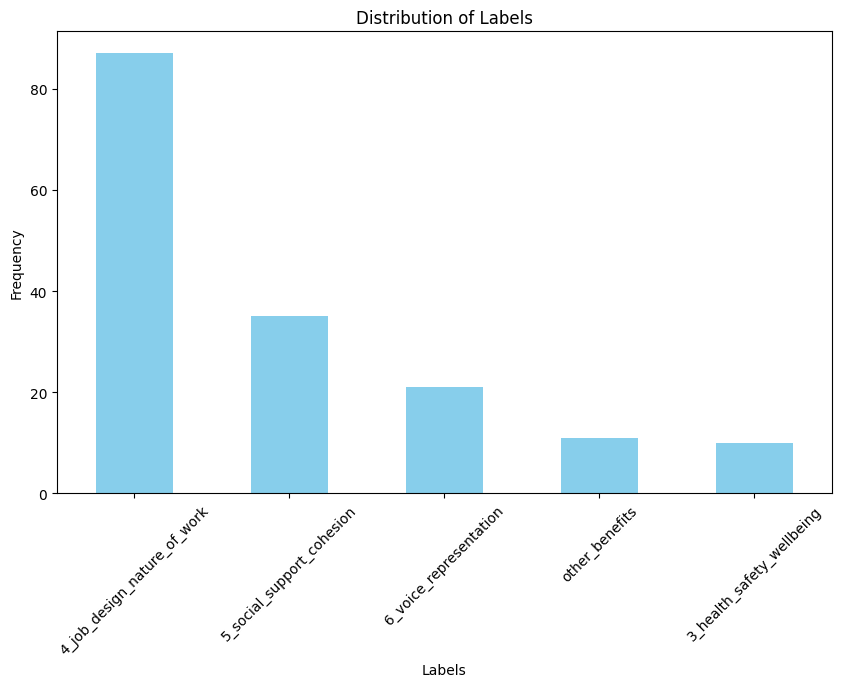

In [7]:
# Bar plot for the distribution of labels
plt.figure(figsize=(10, 6))
labelled_spans_df[(labelled_spans_df['label'] != 'none') & (labelled_spans_df['label'] != 'benefit')]['label'].value_counts().plot(kind='bar', color='skyblue')
plt.title('Distribution of Labels')
plt.xlabel('Labels')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.show()

Inspect the sentences that occur under each label:

In [8]:
# What comes under `other_benefits`?
other_benefits = labelled_spans_df[labelled_spans_df['label'] == 'other_benefits']
other_benefits[['labelled_span']]

,labelled_span
56,Roc Search have been listed in 'The Sunday Times 100 Best Small Companies to work for' for the 6th consecutive year
57,"Gold accredited 'Investors in People,'"
66,This is a 'Outstanding' school by Ofsted
81,a firm recognised amongst 'The Times Best Law Firms 2021'
85,Award Winning Team.
143,This role is supported by Starting Off’s Business Administration - Level 3 apprenticeship with 20% off the job training allocated
152,We are the market leader
158,our core values are · We treat patients and each other as we would like to be treated · We act with integrity · We embrace diversity · We strive to do things better together
162,"Our four core values are Quality, Respect, Compassion, and Community"
221,We are also proud to have been named a 'Top Employer' for 7 consecutive years


In [9]:
# What about `6_voice_representation`?
voice_representation = labelled_spans_df[labelled_spans_df['label'] == '6_voice_representation']
voice_representation[['labelled_span']]
# could have just regexed "equal opportunities"

,labelled_span
28,"Webrecruit and our clients are equal opportunities employers, value diversity and are strongly committed to providing equal employment opportunities for all employees and all applicants for employment. Equal opportunities are the only acceptable way to conduct business and we believe that the more inclusive our environments are, the better our work will be."
44,Atalian Servest is an equal opportunities employer that relies on diversity and equality to achieve our goals.
45,"We actively encourage applications from talented and qualified individuals regardless of race, gender, national origin, religion, sexual orientation, disability, or age."
51,Office Angels UK is an Equal Opportunities Employer.
52,Mc. Gregor Boyall is an equal opportunity employer and do not discriminate on any grounds.
78,"We are committed to hiring great Team Members from a wide variety of backgrounds ensuring that everyone feels respected, valued and celebrated for what they bring to our business"
95,Better People Ltd is an equal opportunities employer
126,"Equal Opportunities We are committed to promoting equality of opportunity for all staff and job applicants. We aim to create a working environment in which all individuals are able to make best use of their skills, free from discrimination or harassment, and in which all decisions are based on merit.Our selection for recruitment does not discriminate on the basis of age, disability, gender reassignment, marital or civil partner status, pregnancy or maternity, race, colour, nationality, ethnicity, ethnic or national origin, religion or belief, sex or sexual orientation or gender reassignment status (protected characteristics).Your"
133,Netbox Recruitment are an equal opportunities employer
159,"At Practice Plus Group we actively promote diversity and equal opportunities and we are committed to this in both the running of our prison healthcare service and how we recruit our staff. We actively encourage applications from everyone with the essential requirements of the job, regardless of any protected characteristics."


In [10]:
social_support = labelled_spans_df[labelled_spans_df['label'] == '5_social_support_cohesion']
social_support[['labelled_span']]

,labelled_span
1,Onsite Management team for ongoing support
12,Great culture and business to be a part of
19,. Teamwork and collaboration are key to our success
20,They are an equal opportunity employer with inclusion and diversity at the heart of our recruitment policy.
21,excellent candidate retention
33,"Not only will you be reporting to the Finance Director, but you will be fully supported and trained by her as well."
34,"This is one of the great advantages of working for a smaller company as you aren't' just a number, you are a key player to the team."
35,"It is a relaxed, non-pressurised environment where everyone gets along and loves to work here!"
36,office environment and culture great
41,Supportive working culture


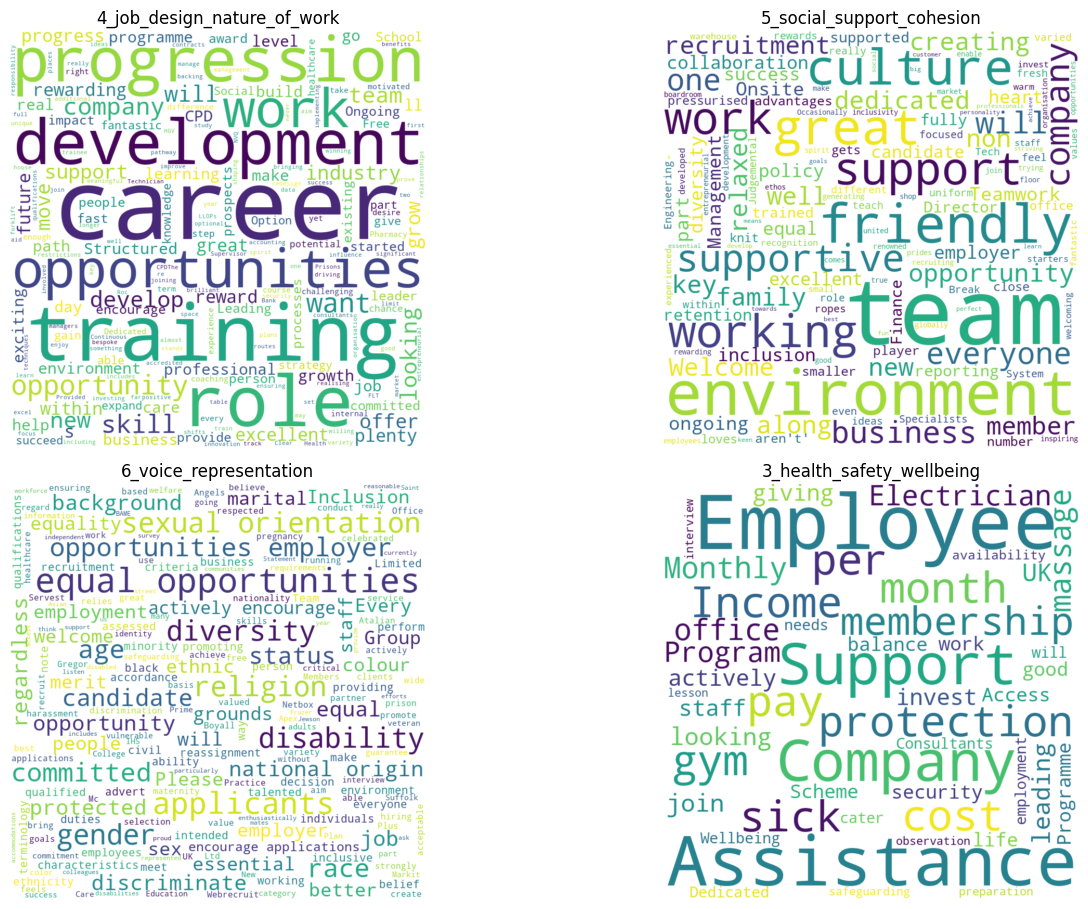

In [11]:
# Wordcloud for each label
label_categories = labelled_spans_df['label'].unique()
label_categories = label_categories[(label_categories != 'benefit') & (label_categories != 'other_benefits') & (label_categories != 'none')]

output_dir = PROJECT_DIR / 'outputs/figures/wordclouds.png'

eda.make_wordclouds(labelled_spans_df, label_categories, output_dir)

In [12]:
common_words = eda.most_common_ngrams(labelled_spans_df, 1)
common_bigrams = eda.most_common_ngrams(labelled_spans_df, 2)
common_trigrams = eda.most_common_ngrams(labelled_spans_df, 3)

In [13]:
for category in common_words:
    if category != 'benefit':
        print(f"Category: {category}")
        print("Most common words:", common_words[category])
        print("Most common bigrams:", common_bigrams[category])
        print("Most common trigrams:", common_trigrams[category])
        print("\n")


Category: 4_job_design_nature_of_work
Most common words: [(('career',), 26), (('training',), 16), (('progression',), 12), (('development',), 11), (('opportunities',), 11), (('work',), 11), (('role',), 10), (('opportunity',), 9), (('want',), 9), (('company',), 7)]
Most common bigrams: [(('career', 'progression'), 7), (('career', 'path'), 3), (('progression', 'opportunities'), 3), (('career', 'development'), 2), (('structured', 'career'), 2), (('career', 'prospects'), 2), (('social', 'care'), 2), (('plenty', 'opportunities'), 2), (('progress', 'career'), 2), (('training', 'support'), 2)]
Most common trigrams: [(('structured', 'career', 'path'), 2), (('career', 'progression', 'team'), 1), (('progression', 'team', 'leading'), 1), (('team', 'leading', 'supervisor'), 1), (('leading', 'supervisor', 'roles'), 1), (('ongoing', 'training', 'including'), 1), (('training', 'including', 'flt'), 1), (('including', 'flt', 'llops'), 1), (('structured', 'pathway', 'career'), 1), (('pathway', 'career', 

## Part 2: relate insights from labelled data to OJO sample

Load in a sample of 100,000 OJO ads and perform basic keyword searches.

In [14]:
unlabelled_data = get_ojo_sample()
unlabelled_data['clean_description'] = unlabelled_data['description'].apply(tc.clean_text)
unlabelled_data.head()

2024-03-11 14:18:01,675 - aiobotocore.credentials - INFO - Found credentials in shared credentials file: ~/.aws/credentials


,id,job_title_raw,created,description,itl_3_code,itl_3_name,clean_description
0,41548927,Operatives required for Crawley Covid-19 Testing Centre,2020-12-11 00:00:00,"[ Operatives required for Slough Covid-19 Testing Centre Berkeley Scott is currently recruiting for operatives for a Covid testing centre in the Crawley area. The role would be working at the Crawley test centre to meet and greet and show the members of the public who require a Covid test where to go. PPE will be provided plus a full induction will be completed on your first day. The shifts will be 4 days on and 4 days off each week. Shifts will be 12 hours and the site is open Monday-Sunday. So please be flexible when receiving the rota. The hourly rate for the role is £10.00 plus holiday pay. To work for Berkeley Scott, we require: Relevant working experience Passport NI Number Bank details Proof of address Full Uniform - (Black shirt, black trousers and black shoes) Please apply today, so we can get you out to work as soon as possible! ]",TLJ28,West Sussex (North East),"Operatives required for Slough Covid-19 Testing Centre Berkeley Scott is currently recruiting for operatives for a Covid testing centre in the Crawley area. The role would be working at the Crawley test centre to meet and greet and show the members of the public who require a Covid test where to go. PPE will be provided plus a full induction will be completed on your first day. The shifts will be 4 days on and 4 days off each week. Shifts will be 12 hours and the site is open Monday-Sunday. So please be flexible when receiving the rota. The hourly rate for the role is £10.00 plus holiday pay. To work for Berkeley Scott, we require Relevant working experience Passport NI Number Bank details Proof of address Full Uniform - (Black shirt, black trousers and black shoes) Please apply today, so we can get you out to work as soon as possible!"
1,41549201,Conveyancing Administrator - Guildford,2020-12-11 00:00:00,"[ 2i Recruit are pleased to be recruiting a niche role within the property sector. The prime role of the Conveyancing is to provide direct support to enable relevant parties to operate at optimum efficiency. The role requires a high degree of self-management and initiative. Role and Main Responsibilities Deal with all post exchange work and correspondence including:- o (but not limited to) preparation of Certificate of Titles for signature by fee earners, Transfer Deeds, carry out all pre-completion searches, deal with replies to requisitions, prepare CHAPS and BACS forms (undertaking relevant money laundering checks, where appropriate) o Completion formalities and prepare completion statements for both clients and buyer’s solicitors. o All post-completion formalities including Registration, Land Registry Forms and AP1s o Undertaking on-line form filling requirements including SDLT forms o Obtaining information from local authorities and other organisations o Generation of suit...",TLJ25,West Surrey,"2i Recruit are pleased to be recruiting a niche role within the property sector. The prime role of the Conveyancing is to provide direct support to enable relevant parties to operate at optimum efficiency. The role requires a high degree of self-management and initiative. Role and Main Responsibilities Deal with all post exchange work and correspondence including - o (but not limited to) preparation of Certificate of Titles for signature by fee earners, Transfer Deeds, carry out all pre-completion searches, deal with replies to requisitions, prepare CHAPS and BACS forms (undertaking relevant money laundering checks, where appropriate) o Completion formalities and prepare completion statements for both clients and buyer’s solicitors. o All post-completion formalities including Registration, Land Registry Forms and AP1s o Undertaking on-line form filling requirements including SDLT forms o Obtaining information from local authorities and other organisations o Generation of suitab..."
2,41549651,Main

### Keyword search

We make a dict of search terms where the key is the CIPD dimension or subdimension and the values are the exact terms to search for. These are pruned versions of the bigrams/trigrams above.

In [15]:
phrases = {"job design and nature of work": ['career progression', 'career prospects', 'career development', 'progression opportunities', 'ongoing training', "opportunities for progression", 'learning and development'],
           "social support and cohesion": ["relaxed environment", "friendly working environment", "ongoing support", "great culture"],
           # reward/recognition seems a little trickier, so I decided to see how many ads contained these phrases specifically
           "reward": ["making a difference", "make a difference", "sense of purpose"]
           }

In [16]:
purpose_results = unlabelled_data[unlabelled_data['clean_description'].str.contains('|'.join(phrases["reward"]))]
purpose_results.head()

,id,job_title_raw,created,description,itl_3_code,itl_3_name,clean_description
8,41552091,Support Worker,2020-12-11 00:00:00,"[ Huntercombe Maidenhead is a Tier 4 Child and Adolescent Mental Health (CAMHS) hospital in Taplow, Maidenhead where we look after children and young people aged 12 to 18 years with mental health needs. We are recruiting Youth Support Workers to join our expanding team of nurses, therapists and medical specialists to make a difference to our patients care and recovery. Salary: £10.03 per hour Full time / Part time / Bank / Nights When you join The Huntercombe Group as a Youth Support Worker, you will be part of a company that is understanding, strives towards excellence, is reliable and above all puts people first. Working with The Huntercombe Group is rewarding and varied. Through our ""Conversation into Action"" programme we actively encourage our employees to get involved and to drive service change for the better. The role involves working as part of our nursing team, to deliver individualised care to patients, implementing person-centred care plans and undertaking a broad range...",TLJ13,Buckinghamshire CC,"Huntercombe Maidenhead is a Tier 4 Child and Adolescent Mental Health (CAMHS) hospital in Taplow, Maidenhead where we look after children and young people aged 12 to 18 years with mental health needs. We are recruiting Youth Support Workers to join our expanding team of nurses, therapists and medical specialists to make a difference to our patients care and recovery. Salary £10.03 per hour Full time Part time Bank Nights When you join The Huntercombe Group as a Youth Support Worker, you will be part of a company that is understanding, strives towards excellence, is reliable and above all puts people first. Working with The Huntercombe Group is rewarding and varied. Through our ""Conversation into Action"" programme we actively encourage our employees to get involved and to drive service change for the better. The role involves working as part of our nursing team, to deliver individualised care to patients, implementing person-centred care plans and undertaking a broad range o..."
33,41558665,School &amp; College Leaver Management Consulting Manchester 2021,2020-12-12 00:00:00,"[Our Consulting practice is focused on results, supporting our clients with fast track, profitable growth. We use our understanding of how business works and a knowledge of how the right technology in the right place can create competitive advantage.Our clients might want us to help them enter new markets; address the challenges created by organisational change; or draw up a sustainability strategy that aligns their commercial objectives with broader environmental and social concerns. Our clients range from household names across a diverse range of industries, everyone from big-name broadcasters and high-street banks, to multinational telecoms operators and energy companies.You'll get to work closely with the best in industry, finance and government in the UK and abroad, bringing fresh insights and motivation to the problems they face.You'll help clients look at things in new ways, make suggestions and change things when needed. And as every client is different, the work is really...",TLD37,Greater Manchester North East,"Our Consulting practice is focused on results, supporting our clients with fast track, profitable growth. We use our understanding of how business works and a knowledge of how the right technology in the right place can create competitive advantage.Our clients might want us to help them enter new markets; address the challenges created by organisational change; or draw up a sustainability strategy that aligns their commercial objectives with broader environmental and social concerns. Our clients range from household names across a diverse range of industries, everyone from big-name broadcasters and high-street banks, to multinational telecoms operators and energy companies.You'll get to work closely with th

In [17]:
search_results = unlabelled_data[unlabelled_data['clean_description'].str.contains('|'.join(phrases["job design and nature of work"]))]
search_results.head()

,id,job_title_raw,created,description,itl_3_code,itl_3_name,clean_description
23,41556226,Lead Domain Architect Ref. 2170,2020-12-12 00:00:00,"[MI6 exists to collect secret foreign intelligence that helps protect the UK's security and prosperity. This intelligence is gathered all over the world and reported to the Government - informing policies that counter threats to this country including weapons proliferation, terrorism and regional instabilityWho we areArchitecture and technology is central to MI6 successful operations and intelligence delivery. There is a constant need to develop and maintain capabilities that provide us with mission advantage in an increasingly rapidly changing, technology and data driven world. MI6 is transforming itself into a digitally driven organisation operating within a wider digital UK and partner Intelligence Community.We use agile and lean methodologies to innovate, deliver and upgrade products that are core to MI6's operations, working across the full spectrum of agent operations, data analysis, covert action as well as corporate areas of the organisation. Our products are built using...",TLI,London,"MI6 exists to collect secret foreign intelligence that helps protect the UK's security and prosperity. This intelligence is gathered all over the world and reported to the Government - informing policies that counter threats to this country including weapons proliferation, terrorism and regional instability. Who we are. Architecture and technology is central to MI6 successful operations and intelligence delivery. There is a constant need to develop and maintain capabilities that provide us with mission advantage in an increasingly rapidly changing, technology and data driven world. MI6 is transforming itself into a digitally driven organisation operating within a wider digital UK and partner Intelligence Community.We use agile and lean methodologies to innovate, deliver and upgrade products that are core to MI6's operations, working across the full spectrum of agent operations, data analysis, covert action as well as corporate areas of the organisation. Our products are built us..."
26,41557234,IT Helpdesk Support Lead,2020-12-12 00:00:00,"[Tradition is currently seeking to appoint an IT Helpdesk Support Lead, reporting into the Head of IT Support and Communications, based within the London office to work alongside Traditions' global IT team based in various locations over EMEA, APAC and Americas.This position will incorporate the following activities: Management and control of ticket management and service request functions for IT Helpdesk team.Daily running and incident/request flow of the IT Helpdesk service/team ensuring the team adhere to service level targets.Be the next point of escalation where required for the team/service.Generation of weekly incident and request reports and presentation to senior management with recommendations.Use data analysis skills to ensure productivity and highlight key areas where improvement can be made.Liaising with other IT heads/managers to ensure that newly defined processes are seamlessly incorporated within the IT ecosystem.Contribute to improving customer support by activel...",TLI,London,"Tradition is currently seeking to appoint an IT Helpdesk Support Lead, reporting into the Head of IT Support and Communications, based within the London office to work alongside Traditions' global IT team based in various locations over EMEA, APAC and Americas.This position will incorporate the following activities Management and control of ticket management and service request functions for IT Helpdesk team.Daily running and incident request flow of the IT Helpdesk service team ensuring the team adhere to service level targets.Be the next point of escalation where required for the team service.Generation of weekly incident and request reports and presentation to senior management with recommendations.Use data analysis skills to ensure productivity and highlight key ar

In [18]:
social_results = unlabelled_data[unlabelled_data['clean_description'].str.contains('|'.join(phrases["social support and cohesion"]))]
len(social_results)

1126

In [19]:
print(f"{len(search_results)/len(unlabelled_data)} of the job descriptions contain at least one of the career progression phrases")

0.11866 of the job descriptions contain at least one of the career progression phrases


In [20]:
# Create new columns for (a) job design and nature of work phrases; (b) more specific purpose-related phrases
unlabelled_data[["jdnw_phrase", "jdnw_sentence"]] = unlabelled_data.apply(lambda row: eda.find_phrase_and_sentence(row["clean_description"], phrases["job design and nature of work"]), axis=1, result_type='expand')
unlabelled_data[["purpose_phrase", "purpose_sentence"]] = unlabelled_data.apply(lambda row: eda.find_phrase_and_sentence(row["clean_description"], phrases["reward"]), axis=1, result_type='expand')

In [21]:
print(f"Number of exact mentions of 'learning and development': {sum('learning and development' in desc.lower() for desc in unlabelled_data['clean_description'].unique())}")

Number of exact mentions of 'learning and development': 2921


## spaCy collocations

... a possible next step